# Project Assignment: Short Video Recommender System (KuaiRec)

## Objective
Design and implement a recommender system that provides personalized short video suggestions to users by leveraging their preferences, interaction history, and video content from the KuaiRec dataset. The goal is to build a scalable recommendation engine akin to those powering platforms such as TikTok or Kuaishou.

### Install the Dataset

In [1]:
%%bash
wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=1qe5hOSBxzIuxBb1G_Ih5X-O65QElollE&export=download&confirm=t&uuid=b2002093-cc6e-4bd5-be47-9603f0b33470
' -O KuaiRec.zip
unzip KuaiRec.zip -d data_final_project
mv "data_final_project/KuaiRec 2.0" data_final_project/KuaiRec

--2025-05-17 09:29:45--  https://drive.usercontent.google.com/download?id=1qe5hOSBxzIuxBb1G_Ih5X-O65QElollE&export=download&confirm=t&uuid=b2002093-cc6e-4bd5-be47-9603f0b33470%0A
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 216.58.213.65, 2a00:1450:4007:806::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|216.58.213.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 431964858 (412M) [application/octet-stream]
Saving to: ‘KuaiRec.zip’

     0K .......... .......... .......... .......... ..........  0% 6.42M 64s
    50K .......... .......... .......... .......... ..........  0% 8.45M 56s
   100K .......... .......... .......... .......... ..........  0% 9.29M 52s
   150K .......... .......... .......... .......... ..........  0% 19.3M 45s
   200K .......... .......... .......... .......... ..........  0% 7.21M 47s
   250K .......... .......... .......... .......... ..........  0% 7.54M 48s
   300K ......

Archive:  KuaiRec.zip
   creating: data_final_project/KuaiRec 2.0/
  inflating: data_final_project/KuaiRec 2.0/LICENSE  
  inflating: data_final_project/KuaiRec 2.0/Statistics_KuaiRec.ipynb  
   creating: data_final_project/KuaiRec 2.0/data/
  inflating: data_final_project/KuaiRec 2.0/data/big_matrix.csv  
  inflating: data_final_project/KuaiRec 2.0/data/item_categories.csv  
  inflating: data_final_project/KuaiRec 2.0/data/item_daily_features.csv  
  inflating: data_final_project/KuaiRec 2.0/data/kuairec_caption_category.csv  
  inflating: data_final_project/KuaiRec 2.0/data/small_matrix.csv  
  inflating: data_final_project/KuaiRec 2.0/data/social_network.csv  
  inflating: data_final_project/KuaiRec 2.0/data/user_features.csv  
   creating: data_final_project/KuaiRec 2.0/figs/
  inflating: data_final_project/KuaiRec 2.0/figs/KuaiRec.png  
  inflating: data_final_project/KuaiRec 2.0/figs/colab-badge.svg  
  inflating: data_final_project/KuaiRec 2.0/loaddata.py  


### Install Dependencies

In [ ]:
!pip install pandas numpy matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Importing Libraries

In [30]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load the Dataset

In [31]:
train_dataset = pd.read_csv("data_final_project/KuaiRec/data/big_matrix.csv")
test_dataset = pd.read_csv("data_final_project/KuaiRec/data/small_matrix.csv")

In [32]:
train_dataset.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


### Preprocess the Data

In [33]:
# drop the columns that are not needed
train_dataset.dropna(inplace=True)
train_dataset.drop_duplicates(inplace=True)

In [34]:
# under the limit threshold, the videos are considered not relevant
limit = 2000

# keep only the videos that have at least x interactions
video_ids_to_keep = (
    train_dataset.groupby("video_id").size().sort_values(ascending=False) >= limit
)
video_ids_to_keep = video_ids_to_keep[video_ids_to_keep]
train_set_filtered = train_dataset[train_dataset["video_id"].isin(video_ids_to_keep.index)]

(0.0, 5.0)

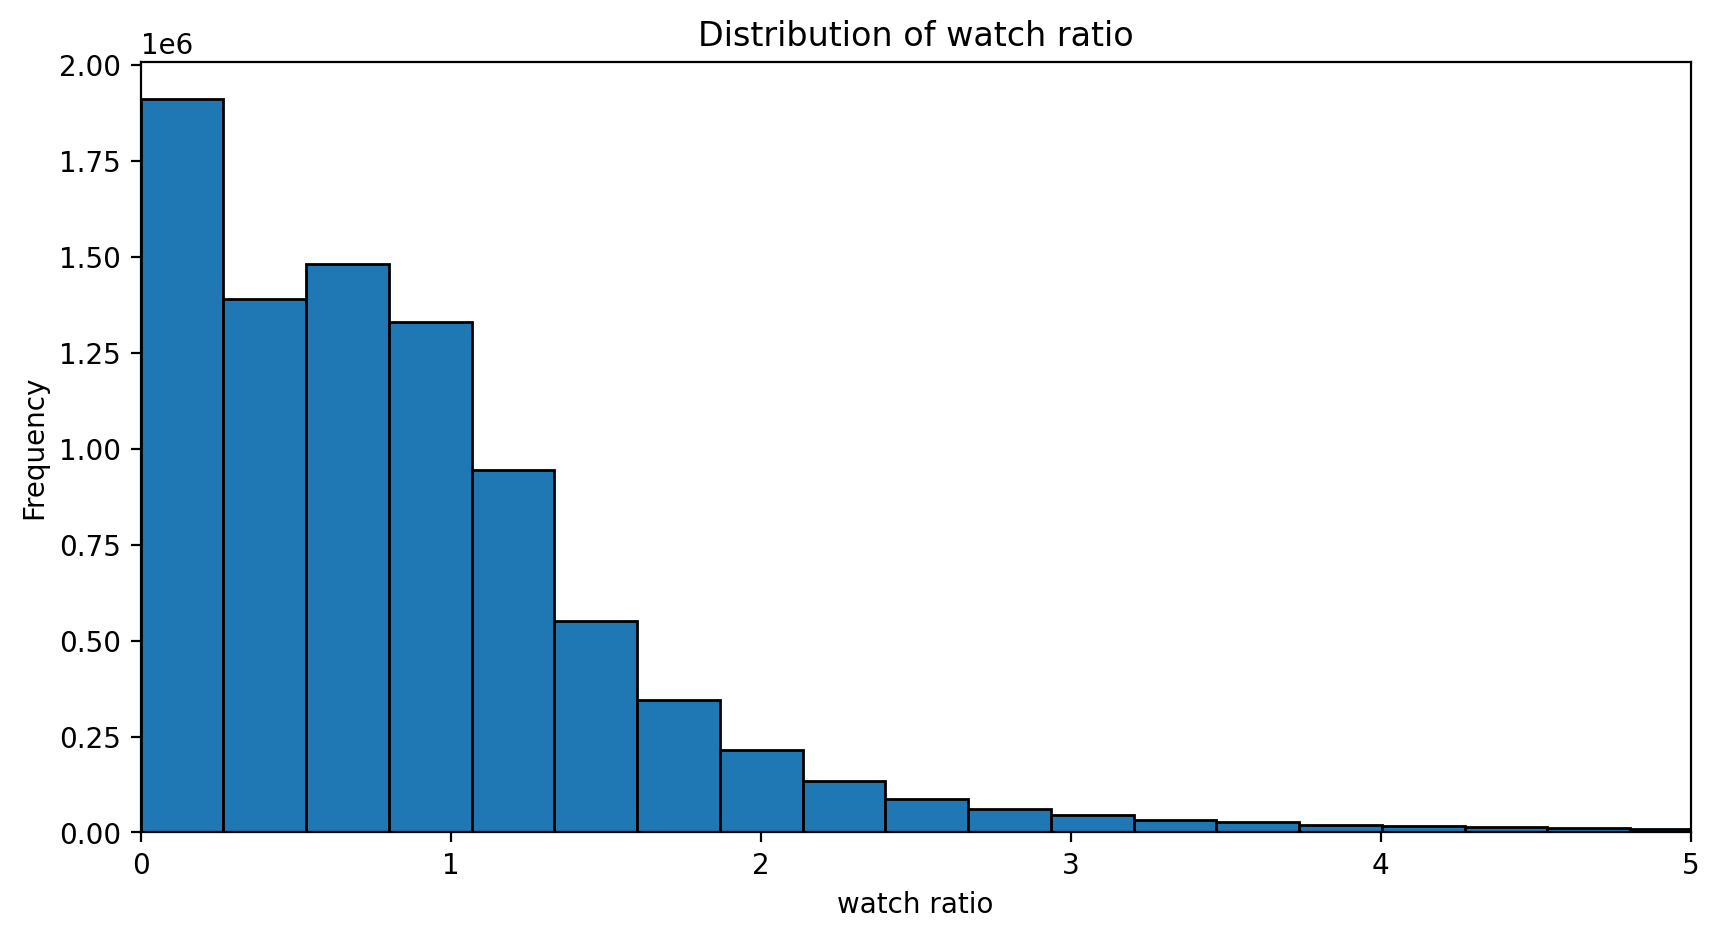

In [35]:
# Plot the distribution of watch_ratio
plt.figure(figsize=(10, 5))
plt.hist(train_set_filtered["watch_ratio"], bins=1000, edgecolor="black")
plt.title("Distribution of watch ratio")
plt.xlabel("watch ratio")
plt.ylabel("Frequency")
plt.xlim(0, 5)

/tmp/ipykernel_10699/487437425.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_filtered["watch_ratio"] = train_set_filtered.loc[:, "watch_ratio"].apply(


Text(0, 0.5, 'Frequency')

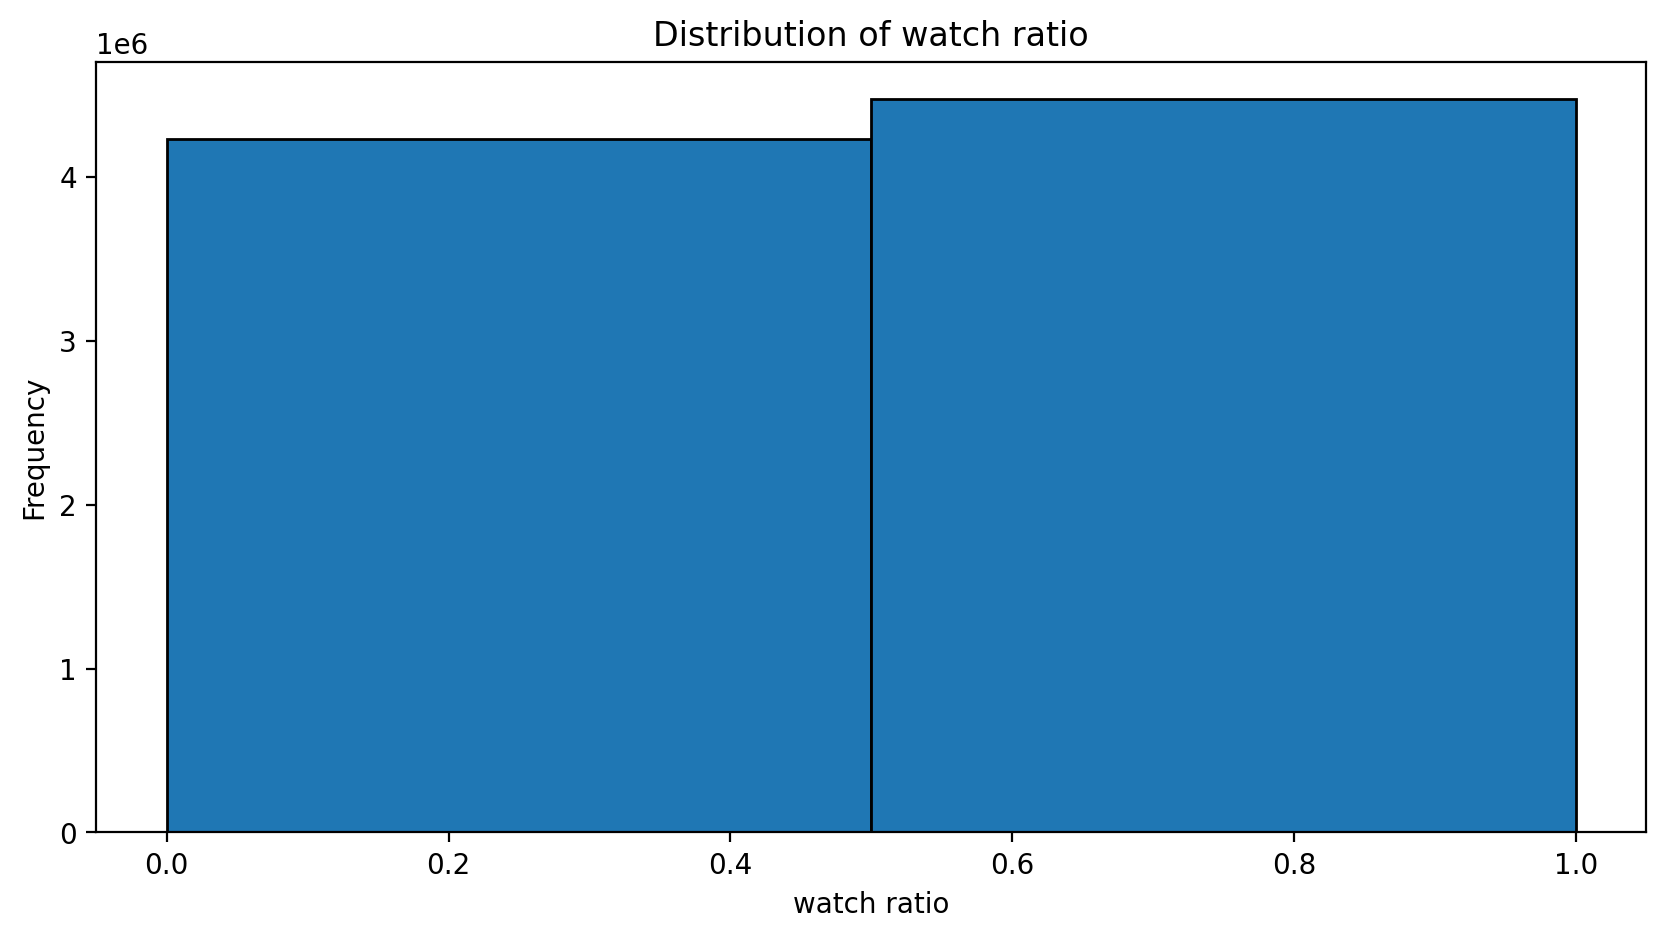

In [36]:
# the limit is the threshold to consider a watch ratio as relevant
# we can set the limit to 0.7, which means that the user watched at least 70% of the video
limit = 0.7

train_set_filtered["watch_ratio"] = train_set_filtered.loc[:, "watch_ratio"].apply(
    lambda x: 0 if x < limit else 1
)
plt.figure(figsize=(10, 5))
plt.hist(train_set_filtered.loc[:, "watch_ratio"], bins=2, edgecolor="black")
plt.title("Distribution of watch ratio")
plt.xlabel("watch ratio")
plt.ylabel("Frequency")

In [37]:
# Pivot the filtered training set to create a user-item interaction matrix,
# where rows are user_ids, columns are video_ids, and values are watch_ratio
train_set_filtered = train_set_filtered.pivot_table(
    index="user_id", columns="video_id", values="watch_ratio"
)
# Fill NaN values with -1
train_set_filtered = train_set_filtered.fillna(-1)
train_set_filtered.head()

video_id,139,145,147,148,151,152,153,154,164,166,...,10457,10462,10492,10500,10506,10519,10552,10589,10595,10640
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,-1.0,0.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,0.0,...,-1.0,0.5,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-1.0
1,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,0.5,...,0.0,-1.0,-1.0,0.5,1.0,1.0,0.0,1.0,1.0,0.0
2,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,0.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
3,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,...,0.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [38]:
kuairec_caption_category = pd.read_csv("data_final_project/KuaiRec/data/kuairec_caption_category.csv", engine="python")

In [39]:
# drop the columns that are not needed
kuairec_caption_category.dropna(inplace=True)
kuairec_caption_category.drop_duplicates(inplace=True)
kuairec_caption_category.drop(columns=["manual_cover_text", "first_level_category_id", "first_level_category_name", "second_level_category_id", "second_level_category_name", "third_level_category_id", "third_level_category_name"], inplace=True)

In [40]:
kuairec_caption_category.head()

,video_id,caption,topic_tag
0,0,精神小伙路难走 程哥你狗粮慢点撒,[]
2,2,晚饭后，运动一下！,[]
3,3,我平淡无奇，惊艳不了时光，温柔不了岁月，我只想漫无目的的走走，努力发笔小财，给自己买花 自己长大.,[]
4,4,#搞笑 #感谢快手我要上热门 #五爱市场 这真是完美搭配啊！,"[五爱市场,感谢快手我要上热门,搞笑]"
5,5,“你们吵的越狠 他们的手就握的越紧” #文轩 #刘耀文 #宋亚轩 #顾子璇...,"[刘耀文,宋亚轩,文轩,顾子璇是樱桃吖,顾子璇超级喜欢文轩]"


In [41]:
# Filter kuairec_caption_category to only include videos present in train_set_filtered columns
kuairec_caption_category_filtered = kuairec_caption_category[kuairec_caption_category["video_id"].astype("int64").isin(train_set_filtered.columns)]
len(kuairec_caption_category_filtered)

2508

In [42]:
kuairec_caption_category_filtered.head()

,video_id,caption,topic_tag
139,139,你好 我叫对象 真名老婆 小名女神 外号宝贝 喜欢那个叫那个.,[]
145,145,一字马脱衣#一字马 #挑战空中一字马 #作品推广 #快手舞蹈 #舞蹈@快手创作者服务中心(O...,"[一字马,作品推广,快手舞蹈,挑战空中一字马,舞蹈]"
147,147,一个可能产生“幸运游客”的地方，景色很美却被遗忘，大美湖南高椅岭 #跟着快手去旅行 #快手创...,"[快手创作者中心,跟着快手去旅行]"
148,148,美60岁奶奶与21少年一见钟情，兴奋分享初次体验，称：升华了感情！ @推广小助手(O4030...,[]
151,151,牛：跟人沾边的事你是一点没干！,[]


## Content-based filtering

In [14]:
# Compute TF-IDF features for the 'caption' column of the filtered video metadata
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(kuairec_caption_category_filtered["caption"])
tfidf_matrix.shape

(2508, 1000)

In [15]:
# One-hot encode the video_id column for the filtered video metadata
onehot = OneHotEncoder()
onehot_matrix = onehot.fit_transform(kuairec_caption_category_filtered[["video_id"]])
onehot_matrix.shape

(2508, 2508)

In [16]:
video_vectors = np.concatenate(
    [
        tfidf_matrix.toarray(),
        onehot_matrix.toarray(),
    ],
    axis=1,
)

In [17]:
# Compute the cosine similarity matrix for the video vectors
cosine_matrix = cosine_similarity(video_vectors)

In [18]:
kuairec_caption_category_filtered.head()

,video_id,caption,topic_tag
139,139,你好 我叫对象 真名老婆 小名女神 外号宝贝 喜欢那个叫那个.,[]
145,145,一字马脱衣#一字马 #挑战空中一字马 #作品推广 #快手舞蹈 #舞蹈@快手创作者服务中心(O...,"[一字马,作品推广,快手舞蹈,挑战空中一字马,舞蹈]"
147,147,一个可能产生“幸运游客”的地方，景色很美却被遗忘，大美湖南高椅岭 #跟着快手去旅行 #快手创...,"[快手创作者中心,跟着快手去旅行]"
148,148,美60岁奶奶与21少年一见钟情，兴奋分享初次体验，称：升华了感情！ @推广小助手(O4030...,[]
151,151,牛：跟人沾边的事你是一点没干！,[]


In [19]:
def recommend_unseen_videos(user_id, k=10):
    """
    Recommend k videos that the user has not already seen.
    :param user_id: The user ID.
    :param k: Number of recommendations.
    :return: DataFrame of recommended videos.
    """
    if user_id not in train_set_filtered.index:
        return None

    # Get videos the user has already seen (watch_ratio != -1)
    seen_videos = set(train_set_filtered.loc[user_id][train_set_filtered.loc[user_id] != -1].index.astype(int))
    # All candidate videos
    all_videos = set(kuairec_caption_category_filtered["video_id"].astype(int))
    # Videos not seen by the user
    unseen_videos = list(all_videos - seen_videos)

    # If less than k unseen videos, return all
    # Recommend k unseen videos most similar to the user's watched videos using cosine similarity
    if not seen_videos:
        # If user hasn't seen any videos, just return k random unseen videos
        recommended_ids = unseen_videos[:k]
    else:
        # Get indices of seen and unseen videos in kuairec_caption_category_filtered
        video_id_list = kuairec_caption_category_filtered["video_id"].astype(int).tolist()
        seen_indices = [video_id_list.index(vid) for vid in seen_videos if vid in video_id_list]
        unseen_indices = [video_id_list.index(vid) for vid in unseen_videos if vid in video_id_list]

        # Compute mean similarity of each unseen video to all seen videos
        if seen_indices and unseen_indices:
            sim_scores = cosine_matrix[unseen_indices][:, seen_indices].mean(axis=1)
            top_k_idx = np.argsort(sim_scores)[::-1][:k]
            recommended_ids = [unseen_videos[i] for i in top_k_idx]
        else:
            recommended_ids = unseen_videos[:k]
    return kuairec_caption_category_filtered[kuairec_caption_category_filtered["video_id"].astype(int).isin(recommended_ids)]

In [20]:
test_dataset["video_id"] = test_dataset["video_id"].astype(int)

precisions = []
recalls = []
ndcgs = []
for user_id in test_dataset["user_id"].unique():
    # Get the recommended videos for the user
    recommended_videos = recommend_unseen_videos(user_id, k=10)
    if recommended_videos is not None and not recommended_videos.empty:
        recommended_ids = set(recommended_videos["video_id"].astype(int))
        user_watched = set(test_dataset[test_dataset["user_id"] == user_id]["video_id"])
        hits = len(recommended_ids & user_watched)
        precision = hits / len(recommended_ids) if recommended_ids else 0
        recall = hits / len(user_watched) if user_watched else 0
        precisions.append(precision)
        recalls.append(recall)
        # Compute nDCG
        # Relevance: 1 if recommended video is in user_watched, else 0
        recommended_list = list(recommended_videos["video_id"].astype(int))
        relevance = [1 if vid in user_watched else 0 for vid in recommended_list]
        def dcg(rel):
            return sum([rel[i] / np.log2(i + 2) for i in range(len(rel))])
        ideal_relevance = sorted(relevance, reverse=True)
        dcg_val = dcg(relevance)
        idcg_val = dcg(ideal_relevance)
        ndcg = dcg_val / idcg_val if idcg_val > 0 else 0
        ndcgs.append(ndcg)
        print(f"Recommended videos for user {user_id}:")
        print(recommended_videos[["video_id", "caption"]])
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
    else:
        print(f"No recommendations available for user {user_id}.")


Recommended videos for user 14:
     video_id                                            caption
778       778  剥好的水果真的很甜 一束花也不是什么高消费 你要明白爱和敷衍是两回事. #感谢快手我要上热门...
800       800    你是我辗转反侧的梦  我是你如梦山河的故人#大海 #日落 #热门 #感谢快手我要上热门 #原创
826       826    坚持七天！你会发现小肚子没有了，大小腿瘦了一圈，穿裤子更好看了，赶快收藏练习吧！#瘦 #热门 
1095     1095                 延迟退休来了，如果你是这五类人，亏可就吃大了！#退休 #热门 #打工
2031     2029                    别出现柠檬精     #辰小希咕咕甜品  #热门 #日常更新 
4360     4358                             你们要的黑鞋 #热门 #感谢快手我要上热门 
5647     5645  这个动作大家都很熟悉啦，坚持下来真的有很大变化呢#自律 #热门 #推广小助手 #感谢快手我要...
7532     7528            #声控 #终结的炽天使 #费娘 #热门 #感谢快手我要上热门 全新版本的开战了
8609     8605                                 #伤感女头 #爱官方爱热门 #热门 
9826     9822   也许他也有他的烦恼吧。 #烦恼 #热门 #快手创作者中心  @推广小助手(O40300047) 
Precision: 1.0000, Recall: 0.0030
Recommended videos for user 19:
     video_id                                            caption
778       778  剥好的水果真的很甜 一束花也不是什么高消费 你要明白爱和敷衍是两回事. #感谢快手我要上热门...
800       800    你是我辗转反侧的梦  我是你如梦山河的故人#大海 #日落 #热门 #感谢快手我要

In [21]:
print(f"Average Precision: {np.mean(precisions):.4f}, Average Recall: {np.mean(recalls):.4f}, Average nDCG: {np.mean(ndcgs):.4f}")

Average Precision: 0.9371, Average Recall: 0.0028, Average nDCG: 0.9955


# Neural Collaborative Filtering

In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Add, Dense
from tensorflow.keras.optimizers import Adam

# Get the number of users and items
num_users = train_set_filtered.shape[0]
num_items = train_set_filtered.shape[1]

# Keras collaborative filtering model (Matrix Factorization)
embedding_size = 64

# User and item input layers
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

# Embedding layers
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=embedding_size, name='item_embedding')(item_input)

# Flatten embeddings
user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

# Dot product of user and item embeddings
dot_product = Dot(axes=1)([user_vec, item_vec])

# Optional: Add bias terms
user_bias = Embedding(input_dim=num_users, output_dim=1, name='user_bias')(user_input)
item_bias = Embedding(input_dim=num_items, output_dim=1, name='item_bias')(item_input)
user_bias_flat = Flatten()(user_bias)
item_bias_flat = Flatten()(item_bias)
pred = Add()([dot_product, user_bias_flat, item_bias_flat])

# Build and compile model
model = Model(inputs=[user_input, item_input], outputs=pred)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 64)        459264      ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 64)        168704      ['item_input[0][0]']             
                                                                                            

In [44]:
# Prepare training data for the collaborative filtering model
# Get user and item indices and corresponding ratings
user_indices, item_indices = np.where(train_set_filtered.values != -1)
ratings = train_set_filtered.values[user_indices, item_indices]

# Fit the model
history = model.fit(
    [user_indices, item_indices],
    ratings,
    epochs=5,
    batch_size=1024,
    validation_split=0.1,
    verbose=1
)

Epoch 1/5
6662/6662 [==============================] - 68s 10ms/step - loss: 0.1796 - val_loss: 0.3192
Epoch 2/5
6662/6662 [==============================] - 77s 12ms/step - loss: 0.1549 - val_loss: 0.3070
Epoch 3/5
6662/6662 [==============================] - 79s 12ms/step - loss: 0.1499 - val_loss: 0.2992
Epoch 4/5
6662/6662 [==============================] - 76s 11ms/step - loss: 0.1473 - val_loss: 0.2933
Epoch 5/5
6662/6662 [==============================] - 108s 16ms/step - loss: 0.1460 - val_loss: 0.2882


In [45]:
def recommend_cf_for_all_users(test_dataset, train_set_filtered, model, k=10):
    """
    Recommend k videos for each user in test_dataset using collaborative filtering.
    Returns a dictionary: {user_id: [recommended_video_ids]}
    """
    # Map user_id and video_id to their indices in train_set_filtered
    user_id_to_idx = {uid: idx for idx, uid in enumerate(train_set_filtered.index)}
    video_id_to_idx = {vid: idx for idx, vid in enumerate(train_set_filtered.columns)}

    recommendations = {}

    for user_id in test_dataset["user_id"].unique():
        if user_id not in user_id_to_idx:
            continue  # skip users not in training set
        print(f"Recommending for user {user_id}")
        # Get user index
        user_idx = user_id_to_idx[user_id]
        # Videos already interacted with
        seen = set(train_set_filtered.columns[train_set_filtered.loc[user_id] != -1].astype(int))
        # Candidate videos: those not seen
        candidate_videos = [vid for vid in train_set_filtered.columns if int(vid) not in seen]
        candidate_indices = [video_id_to_idx[vid] for vid in candidate_videos]

        # Predict scores for all unseen videos
        user_indices = np.full(len(candidate_indices), user_idx)
        item_indices = np.array(candidate_indices)
        preds = model.predict([user_indices, item_indices], verbose=0).flatten()
        # Top k recommendations
        top_k_idx = np.argsort(preds)[::-1][:k]
        recommended_video_ids = [int(candidate_videos[i]) for i in top_k_idx]
        recommendations[user_id] = recommended_video_ids

    return recommendations

cf_recommendations = recommend_cf_for_all_users(test_dataset, train_set_filtered, model, k=20)
# Example: print recommendations for the first 5 users
for uid in list(cf_recommendations.keys())[:5]:
    print(f"User {uid}: {cf_recommendations[uid]}")

Recommending for user 14
Recommending for user 19
Recommending for user 21
Recommending for user 23
Recommending for user 24
Recommending for user 36
Recommending for user 37
Recommending for user 41
Recommending for user 51
Recommending for user 55
Recommending for user 64
Recommending for user 73
Recommending for user 75
Recommending for user 97
Recommending for user 98
Recommending for user 102
Recommending for user 120
Recommending for user 127
Recommending for user 129
Recommending for user 131
Recommending for user 135
Recommending for user 136
Recommending for user 137
Recommending for user 140
Recommending for user 155
Recommending for user 157
Recommending for user 165
Recommending for user 166
Recommending for user 169
Recommending for user 172
Recommending for user 174
Recommending for user 176
Recommending for user 185
Recommending for user 193
Recommending for user 203
Recommending for user 221
Recommending for user 223
Recommending for user 224
Recommending for user 226
R

In [46]:
from collections import defaultdict

def compute_metrics_at_k(cf_recommendations, test_dataset, k=10):
    precisions = []
    recalls = []
    ndcgs = []

    # Build ground truth: user_id -> set of watched video_ids in test set
    user_watched_dict = defaultdict(set)
    for row in test_dataset.itertuples():
        user_watched_dict[row.user_id].add(row.video_id)

    for user_id, recs in cf_recommendations.items():
        recs_at_k = recs[:k]
        gt = user_watched_dict[user_id]
        hits = len(set(recs_at_k) & gt)
        precision = hits / k
        recall = hits / len(gt) if len(gt) > 0 else 0

        # nDCG@k
        relevance = [1 if vid in gt else 0 for vid in recs_at_k]
        def dcg(rel):
            return sum([rel[i] / np.log2(i + 2) for i in range(len(rel))])
        ideal_relevance = sorted(relevance, reverse=True)
        dcg_val = dcg(relevance)
        idcg_val = dcg(ideal_relevance)
        ndcg = dcg_val / idcg_val if idcg_val > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
    print(f"Average Precision: {np.mean(precisions):.4f}, Average Recall: {np.mean(recalls):.4f}, Average nDCG: {np.mean(ndcgs):.4f}")

compute_metrics_at_k(cf_recommendations, test_dataset, k=20)

Average Precision: 0.9332, Average Recall: 0.0056, Average nDCG: 0.9690
